# LeNet

#### Notebook
- [some cool guy on github](https://colab.research.google.com/github/bentrevett/pytorch-image-classification/blob/master/2_lenet.ipynb)

## Data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.utils.data as data
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt 
import numpy as np 
from tqdm.notebook import tqdm, trange

import copy 
import random
import time

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [23]:
root = './outputs/lenet/'
train_data = datasets.MNIST(root=root,
                            train=True,
                            download=True,
                       )

test_data = datasets.MNIST(root=root,
                           train=False,
                           download=True,
                           )
mean = train_data.data.float().mean()/255
std = train_data.data.float().std()/255

print(f"mean: {mean}, std: {std}")

mean: 0.13066047430038452, std: 0.30810779333114624


In [24]:
train_transforms = transforms.Compose([transforms.RandomRotation(5, fill=0,),
                                      transforms.RandomCrop(28, padding=2),
                                       transforms.ToTensor(),
                                        transforms.Normalize(mean=[mean], std=[std]) ])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[mean], std=[std])])

In [25]:
root = './outputs/lenet/'
train_data = datasets.MNIST(root=root,
                            train=True,
                            download=True,
                            transform = train_transforms)

test_data = datasets.MNIST(root=root,
                           train=False,
                           download=True,
                           transform = test_transforms)
mean = train_data.data.float().mean()/255
std = train_data.data.float().std()/255

print(f"mean: {mean}, std: {std}")

mean: 0.13066047430038452, std: 0.30810779333114624


In [26]:
valid_ratio = 0.9
num_train = int(len(train_data) * valid_ratio)
num_valid = len(train_data) - num_train

train_data, valid_data = data.random_split(train_data, [num_train, num_valid])

In [27]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [28]:
print(f'trainning {len(train_data)} \nvalid: {len(valid_data)} \ntest:{len(test_data)}')

trainning 54000 
valid: 6000 
test:10000


In [29]:
batch_size = 64
train_iter = data.DataLoader(train_data,
                             shuffle=True,
                             batch_size=batch_size)
valid_iter = data.DataLoader(valid_data,
                             batch_size=batch_size)
test_iter = data.DataLoader(test_data,
                            batch_size=batch_size)

## Model

- arch: 
  1. CNN(5x5) => Maxpool(f=2) => ReLU(element wise)
  2. CNN(5x5x6) => Maxpool => ReLU
  3. flatten => linear => ReLU
- Note:
  - you should always apply your activation function after the pooling layer. You will get the exact same results if you apply the activation function before, however this means you will be applying your activation function to a larger number of inputs, increasing the computation required. Using the activation function after the image has been reduced in size means it will be applied to fewer inputs and thus use less computation.

### Model Class

In [30]:
class Lenet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_dim)


    def forward(self, x):
        # x[batch, 1, 28, 28] => MNIST
        x = self.conv1(x)

        # x[batch, 6, 24, 24]
        x = f.max_pool2d(x, kernel_size=2)

        # x[batch, 6, 12, 12]
        x = f.relu(x)

        x = self.conv2(x)

        # x[batch, 16, 8, 8]
        x = f.max_pool2d(x, kernel_size=2)

        # x [batch, 16, 4, 4]
        x = f.relu(x)

        x = x.view(x.shape[0], -1)

        #x[batch, 256]
        h = x

        x = self.fc1(x)
        x = f.relu(x)

        #x[batch, 120]
        x = self.fc2(x)
        x = f.relu(x)

        #x[batch, output]
        x = self.fc3(x)

        return x, h

In [31]:
output_DIM = 10
model = Lenet(output_DIM)

In [32]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad())

print(F' MODEL HAS{count_params(model):,} trainable params')

TypeError: 'bool' object is not callable

waaay fewer params than MLP

### Train

In [33]:
optimizer = optim.Adam(model.parameters())

In [34]:
criterion = nn.CrossEntropyLoss() # applies softmax as well

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
model = model.to(device)
criterion = criterion.to(device)

In [37]:
def acc(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    accuracy = correct.float() / y.shape[0]
    return accuracy

In [45]:
def train(model, iterator, optimizer, criterion, device):
    e_loss = 0
    e_acc = 0

    model.train()

    for (x,y) in tqdm(iterator, desc='Training', leave=False):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred , _ = model(x)

        loss = criterion(y_pred, y)

        accuracy = acc(y_pred, y)

        loss.backward()

        optimizer.step()

        e_loss+=loss.item()
        e_acc += accuracy.item()
    return e_loss / len(iterator) , e_acc/ len(iterator)

In [46]:
def eval(model, iterator, criterion, device):
    e_loss = 0
    e_acc = 0

    model.eval()
    with torch.no_grad():
        for (x,y) in tqdm(iterator, desc='Evaluating', leave=False):
            x =x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            accuracy = acc(y_pred, y)

            e_loss +=loss.item()
            e_acc += accuracy.item()

    return e_loss / len(iterator), e_acc / len(iterator)

In [47]:
EPOCHS = 20

best_valid_loss = float('inf')
for epoch in trange(EPOCHS, desc='Epochs'):

    train_loss, train_acc = train(model, train_iter, optimizer, criterion, device)
    valid_loss, valid_acc = eval(model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'LeNet.pt')

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01
	Train Loss: 0.032 | Train Acc: 98.99%
	 Val. Loss: 0.031 |  Val. Acc: 99.10%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02
	Train Loss: 0.030 | Train Acc: 99.10%
	 Val. Loss: 0.035 |  Val. Acc: 98.87%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03
	Train Loss: 0.029 | Train Acc: 99.07%
	 Val. Loss: 0.032 |  Val. Acc: 99.14%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04
	Train Loss: 0.028 | Train Acc: 99.08%
	 Val. Loss: 0.027 |  Val. Acc: 99.15%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05
	Train Loss: 0.027 | Train Acc: 99.17%
	 Val. Loss: 0.030 |  Val. Acc: 99.09%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06
	Train Loss: 0.027 | Train Acc: 99.16%
	 Val. Loss: 0.033 |  Val. Acc: 99.09%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07
	Train Loss: 0.028 | Train Acc: 99.13%
	 Val. Loss: 0.038 |  Val. Acc: 99.02%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08
	Train Loss: 0.028 | Train Acc: 99.12%
	 Val. Loss: 0.032 |  Val. Acc: 99.10%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09
	Train Loss: 0.024 | Train Acc: 99.19%
	 Val. Loss: 0.036 |  Val. Acc: 98.90%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10
	Train Loss: 0.026 | Train Acc: 99.14%
	 Val. Loss: 0.035 |  Val. Acc: 99.04%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 11
	Train Loss: 0.027 | Train Acc: 99.14%
	 Val. Loss: 0.034 |  Val. Acc: 99.10%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 12
	Train Loss: 0.025 | Train Acc: 99.22%
	 Val. Loss: 0.034 |  Val. Acc: 99.20%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 13
	Train Loss: 0.026 | Train Acc: 99.15%
	 Val. Loss: 0.033 |  Val. Acc: 99.10%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 14
	Train Loss: 0.025 | Train Acc: 99.22%
	 Val. Loss: 0.026 |  Val. Acc: 99.25%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 15
	Train Loss: 0.023 | Train Acc: 99.23%
	 Val. Loss: 0.029 |  Val. Acc: 99.25%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 16
	Train Loss: 0.024 | Train Acc: 99.19%
	 Val. Loss: 0.029 |  Val. Acc: 99.17%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 17
	Train Loss: 0.023 | Train Acc: 99.28%
	 Val. Loss: 0.028 |  Val. Acc: 99.15%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 18
	Train Loss: 0.021 | Train Acc: 99.25%
	 Val. Loss: 0.031 |  Val. Acc: 99.10%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 19
	Train Loss: 0.024 | Train Acc: 99.24%
	 Val. Loss: 0.032 |  Val. Acc: 99.15%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 20
	Train Loss: 0.021 | Train Acc: 99.34%
	 Val. Loss: 0.037 |  Val. Acc: 99.17%


In [48]:
model.load_state_dict(torch.load('LeNet.pt'))
test_loss, test_acc = eval(model, test_iter, criterion, device)

print(f'test loss{test_loss:.3f} || Test acc {test_acc *100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

test loss0.024 || Test acc 99.27%


### testing model

In [49]:
def predict(model, iterator, device):
    model.eval()

    imgs = []
    lbls = []
    probs = []

    with torch.no_grad():
        for(x,y) in iterator:
            x = x.to(device)
            y_pred , _ = model(x)
            y_prob = f.softmax(y_pred, dim=-1)

            imgs.append(x.cpu())
            lbls.append(y.cpu())
            probs.append(y_prob.cpu())

    imgs = torch.cat(imgs, dim=0)
    lbls = torch.cat(lbls, dim=0)
    probs = torch.cat(probs, dim=0)

    return imgs, lbls, probs

In [50]:
images, labels, probs = predict(model, test_iter, device)

In [51]:
pred_lbls = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

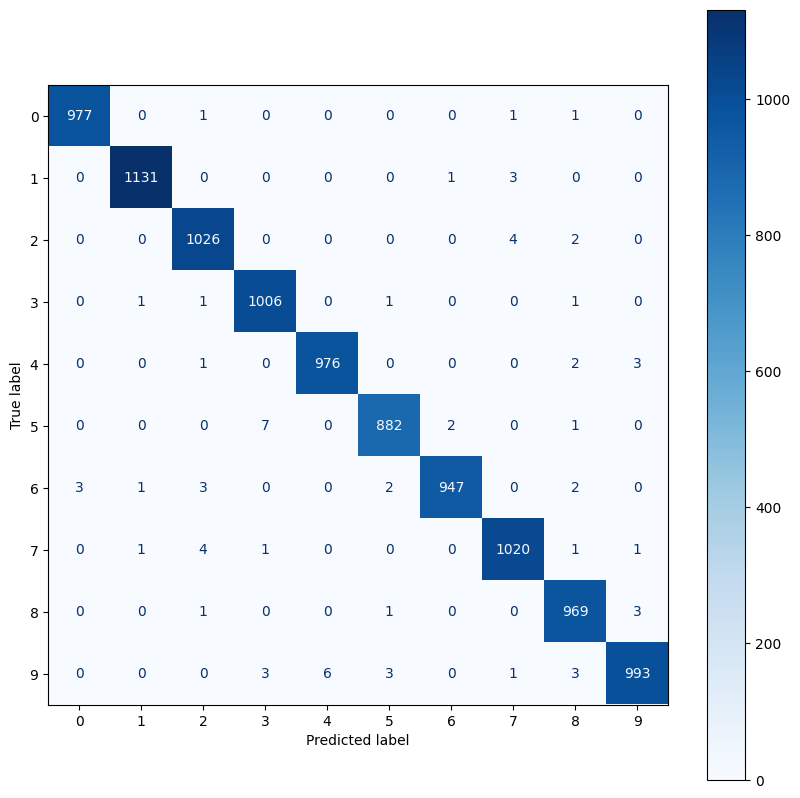

In [53]:
plot_confusion_matrix(labels, pred_lbls)